In [2]:
import os 

os.chdir("app")

In [4]:
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score

In [7]:
path_to_data = 'data'

In [8]:
df = pd.read_csv(path_to_data + "/transactions.csv")

In [9]:
train = pd.read_csv(path_to_data + "/train.csv", index_col=0)

In [10]:
df.head()

,client_id,trans_time,mcc_code,trans_type,amount,term_id,trans_city
0,d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver
1,81c7349f7bdcb661bc7d5f5f0fdac6aa,351 13:27:15,6011,7010,7954.51,442207,Kazan
2,fc0c7c937f139bd6d1c5b5d0a0023dd3,150 16:03:59,6011,2010,-12293.56,NaN,Khabarovsk
3,3495487d5beaa5caaa0682fddc38379a,373 11:54:12,6010,7070,49.52,888987,Kaliningrad
4,07e279042b1da23710fa2f65034d30b9,340 13:11:45,6010,7070,45.29,888918,Saint Petersburg


In [11]:
# remove outliers
df = df[(df['amount'] > df['amount'].quantile(0.01)) & (df['amount'] < df['amount'].quantile(0.99))]

In [12]:
# time features
base_date = pd.to_datetime('2022-01-01')

df['trans_time'] = df['trans_time'].astype(str)
df[['days', 'time']] = df['trans_time'].str.split(' ', expand=True)
df['days'] = pd.to_timedelta(df['days'].astype(int), unit='D')
df['time'] = pd.to_timedelta(df['time'])
df['event_time'] = base_date + df['days'] + df['time']

df['hour'] = df['event_time'].dt.hour
df['minute'] = df['event_time'].dt.minute
df['day_of_week'] = df['event_time'].dt.day_of_week

df['amount_pos'] = df['amount'] * (df['amount']>=0) 
df['amount_neg'] = - df['amount'] * (df['amount']<0)

In [13]:
def generate_pivot_features(df, col, value, aggfunc):
    pivot = df.pivot_table(values=[value], index=['client_id'], columns=[col], aggfunc=aggfunc)
    pivot.columns = [f'{col}_{v}_{value}_{aggfunc}' for _, v in pivot.columns]
    pivot = pivot.reset_index()

    return pivot

In [14]:
def generate_tfidf_features(df, col):
    bot = df.groupby('client_id')[col].apply(lambda x: list(x))
    corpus = [' '.join(map(str, x)) for x in bot]

    tfidf = TfidfVectorizer()
    tfidf.fit(corpus)

    tfidf_features = pd.DataFrame(
        tfidf.transform(corpus).A,
        columns=[f'tfidf_{col}_{k}' for k in tfidf.get_feature_names_out()]
    )
    tfidf_features['client_id'] = bot.index

    return tfidf_features

In [15]:
tfidf_features_mcc = generate_tfidf_features(df, 'mcc_code')
tfidf_features_type = generate_tfidf_features(df, 'trans_type')

mcc_amount = generate_pivot_features(df, 'mcc_code', 'amount', 'mean')
type_amount = generate_pivot_features(df, 'trans_type', 'amount_neg', 'mean')
day_of_week_features = generate_pivot_features(df, 'day_of_week', 'amount', 'mean')
hour_features = generate_pivot_features(df, 'hour', 'amount', 'mean')

In [16]:
amount_agg = df.groupby('client_id').agg({
    'amount_pos': ['mean', 'std', 'max'],
    'amount_neg': ['mean', 'std', 'max'],
    'amount': ['mean', 'std', 'max', 'min'],
}).reset_index()

amount_agg.columns = [f'{head}_{stat}' if stat != '' else head for head, stat in amount_agg.columns]

In [114]:
# merge features
data = (
    tfidf_features_mcc 
    .merge(mcc_amount) 
    .merge(type_amount)
    .merge(tfidf_features_type) 
    .merge(day_of_week_features) 
    .merge(hour_features)
    .merge(amount_agg)
    .merge(train) 
).fillna(0)

In [115]:
# remove features with high correlation
corr = data.corr()
high_corr = (abs(np.tril(corr)) - np.identity(corr.shape[0]) >= 0.8).nonzero()

data = data.drop(corr.columns[high_corr[0]], axis=1)

In [116]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = data_train.drop(['client_id', 'gender'], axis=1)
y_train = data_train['gender']

X_test = data_test.drop(['client_id', 'gender'], axis=1)
y_test = data_test['gender']

In [117]:
def cv_permutation_importance(model, X, y, scoring='roc_auc', cv=5, **kwargs):
    kf = KFold(cv, shuffle=True)

    importances_ = []
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model.fit(X_train, y_train)

        fpi = permutation_importance(model, X_valid, y_valid, scoring=scoring, **kwargs)

        importances_.append(fpi.importances)

    return np.concatenate(importances_, axis=1)

In [120]:
model = LGBMClassifier(n_estimators=500, max_depth=3, reg_alpha=15, reg_lambda=15, verbose=-1)
fpi = cv_permutation_importance(model, X_train, y_train, 'roc_auc')

In [121]:
fpi_series = pd.Series(fpi.mean(axis=1), index=X_train.columns)
selected_features = fpi_series[fpi_series > 0].index

In [122]:
len(selected_features)

130

In [125]:
model = LGBMClassifier(n_estimators=500, max_depth=3, reg_alpha=15, reg_lambda=15, verbose=-1)
model.fit(X_train[selected_features], y_train)

LGBMClassifier(max_depth=3, n_estimators=500, reg_alpha=15, reg_lambda=15,
               verbose=-1)

In [130]:
print(f'Train score: {roc_auc_score(y_train, model.predict_proba(X_train[selected_features])[:, 1]):.4f}')
print(f'Test score: {roc_auc_score(y_test, model.predict_proba(X_test[selected_features])[:, 1]):.4f}')

Train score: 0.9351
Test score: 0.8802


In [131]:
fi = pd.Series(model.feature_importances_, index=selected_features).sort_values()

<BarContainer object of 130 artists>

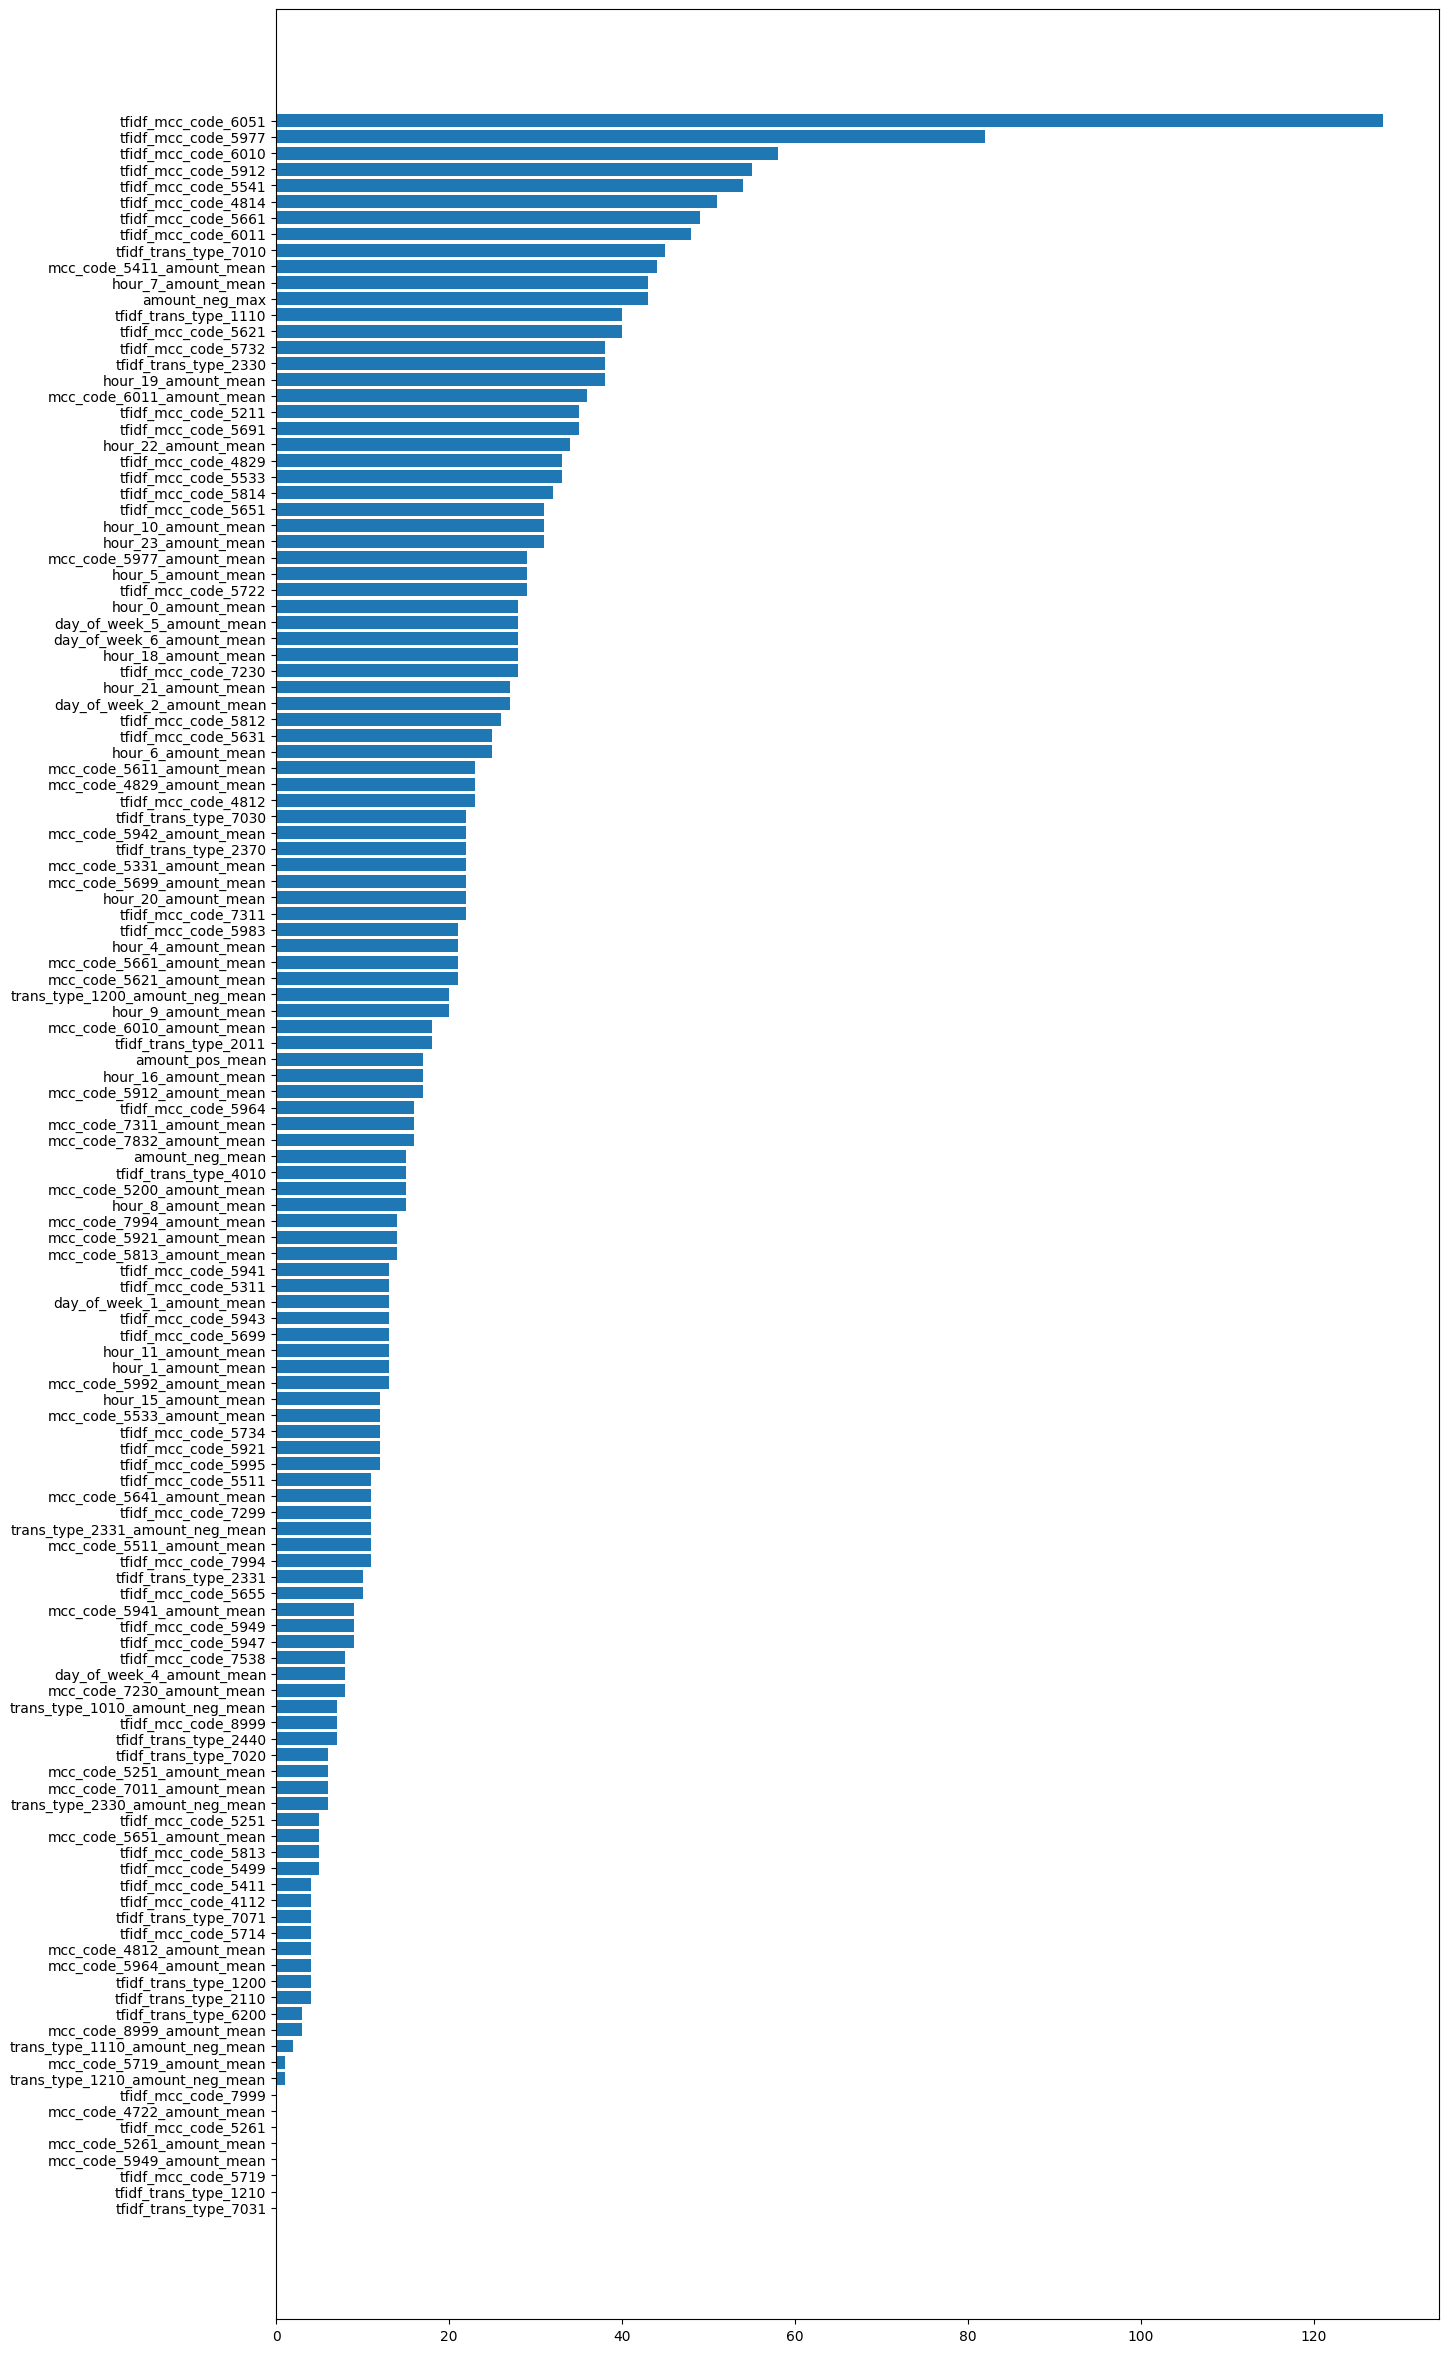

In [133]:
fig, ax = plt.subplots(figsize=(15, 30))
ax.barh(fi.index, fi)

In [137]:
top_mcc = [6051, 5977, 6010, 5912, 5541, 4814, 5661, 6011]
mcc_desc = pd.read_csv(path_to_data + '/mcc_codes.csv', sep=';')

mcc_desc[mcc_desc['mcc_code'].isin(top_mcc)]

,mcc_code,mcc_description
20,4814,"Звонки с использованием телефонов, считывающих..."
65,5541,Станции техобслуживания
75,5661,Обувные магазины
94,5912,Аптеки
116,5977,Магазины косметики
123,6010,Финансовые институты — снятие наличности вручную
124,6011,Финансовые институты — снятие наличности автом...
126,6051,"Не-финансовые институты — иностранная валюта, ..."
